Get the complete data_set, together with the train and test data_set

In [ ]:
from tf_chpvk_pv.dataset import *
import pandas as pd

df = create_dataset()
train_df, test_df = train_test_split_()

ModuleNotFoundError: No module named 'tf_chpvk_pv'

In [2]:
#count the number of material in each class in the training/test sets
dict_ch = {133.15:'F',
           180.61:'Cl',
           198.14:'Se',
           195.56:'Br',
           184.40:'S',
           219.49:'I'
          }

train_df['X'] = train_df.replace({'rX':dict_ch})['rX']
test_df['X'] = test_df.replace({'rX':dict_ch})['rX']

train_vc = pd.DataFrame(train_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())
test_vc = pd.DataFrame(test_df[['X', 'exp_label']].groupby('X')['exp_label'].value_counts())

print('In the training set, %s compositions are unstable and %s are stable.' % (train_df['exp_label'].value_counts().values[0], train_df['exp_label'].value_counts().values[1]))
print('The distribution in the training set by anions is the following')
display(train_vc)

print('In the test set, %s compositions are unstable and %s are stable.' % (test_df['exp_label'].value_counts().values[0], test_df['exp_label'].value_counts().values[1]))
print('The distribution in the test set by anions is the following')
display(test_vc)

In the training set, 141 compositions are unstable and 85 are stable.
The distribution in the training set by anions is the following


count
X  exp_label       
Br 0.0           17
   1.0            4
Cl 0.0           43
   1.0           14
F  1.0           40
   0.0           13
I  0.0           29
   1.0            5
S  0.0           26
   1.0           21
Se 0.0           13
   1.0            1

In the test set, 34 compositions are unstable and 23 are stable.
The distribution in the test set by anions is the following


count
X  exp_label       
Br 0.0            5
   1.0            1
Cl 0.0           10
   1.0            4
F  1.0           11
   0.0            2
I  0.0            7
   1.0            2
S  0.0            7
   1.0            5
Se 0.0            3

Train the SISSO model to obtain the features

In [3]:
from tf_chpvk_pv.features import run_SISSO_model

Inputs = run_SISSO_model()

2025-02-27 01:31:06.611 | SUCCESS  | tf_chpvk_pv.features:run_SISSO_model:68 - SISSO Features were already generated.


Train tree models with the SISSO features, to decide the best t_sisso

2025-02-27 01:31:07.186 | INFO     | tf_chpvk_pv.modeling.train:train_tree_sis_features:81 - Training tree model with SISSO features...
Identified expression for t_sisso: (((rA_rX_ratio - log_rA_rB_ratio) - (rB_rX_ratio / log_rA_rB_ratio)) - (log(log_rA_rB_ratio) - rA_rX_ratio))
Classification tree accuracy (for t_sisso) on the train set: 0.849558.
Classification tree accuracy (for t_sisso) on the train set (5 fold CV): 0.818454.
Classification tree accuracy (for t_sisso) on the test set: 0.877193.
t_sisso < 0.831199 indicates stable perovskites.
Classification tree accuracy (for t) on the train set: 0.637168.
Classification tree accuracy (for t) on the train set (5 fold CV): 0.606280.
Classification tree accuracy (for t) on the test set: 0.596491.
0.868341 < t < 0.909563 indicates stable perovskites.
Classification tree accuracy (for tau) on the train set: 0.884956.
Classification tree accuracy (for tau) on the train set (5 fold CV): 0.880290.
Classification tree accuracy (for tau) on

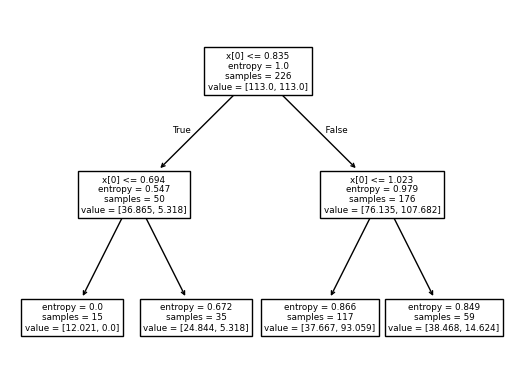

In [4]:
from tf_chpvk_pv.modeling.train import *

t_sisso_expression = train_tree_sis_features()
train_df, test_df, tolerance_factor_dict = evaluate_t_sisso(t_sisso_expression)

tfs = ['t_sisso', 't', 'tau', 't_jess']
tf_tresh = [1, 2, 1, 2]

df_acc =pd.DataFrame()
clfs = {}

for tf, tresh in zip(tfs, tf_tresh):
    df_acc, clf_t = test_tolerance_factor(tf, train_df, test_df, tolerance_factor_dict, df_acc, n_tresh=tresh)
    clfs[tf] = clf_t

In [5]:
df_acc.loc[['train_data', 'test_data', '5-fold CV']]

,t_sisso,t,tau,t_jess
train_data,0.849558,0.637168,0.884956,0.725664
test_data,0.877193,0.596491,0.824561,0.631579
5-fold CV,0.818454,0.60628,0.88029,0.68599


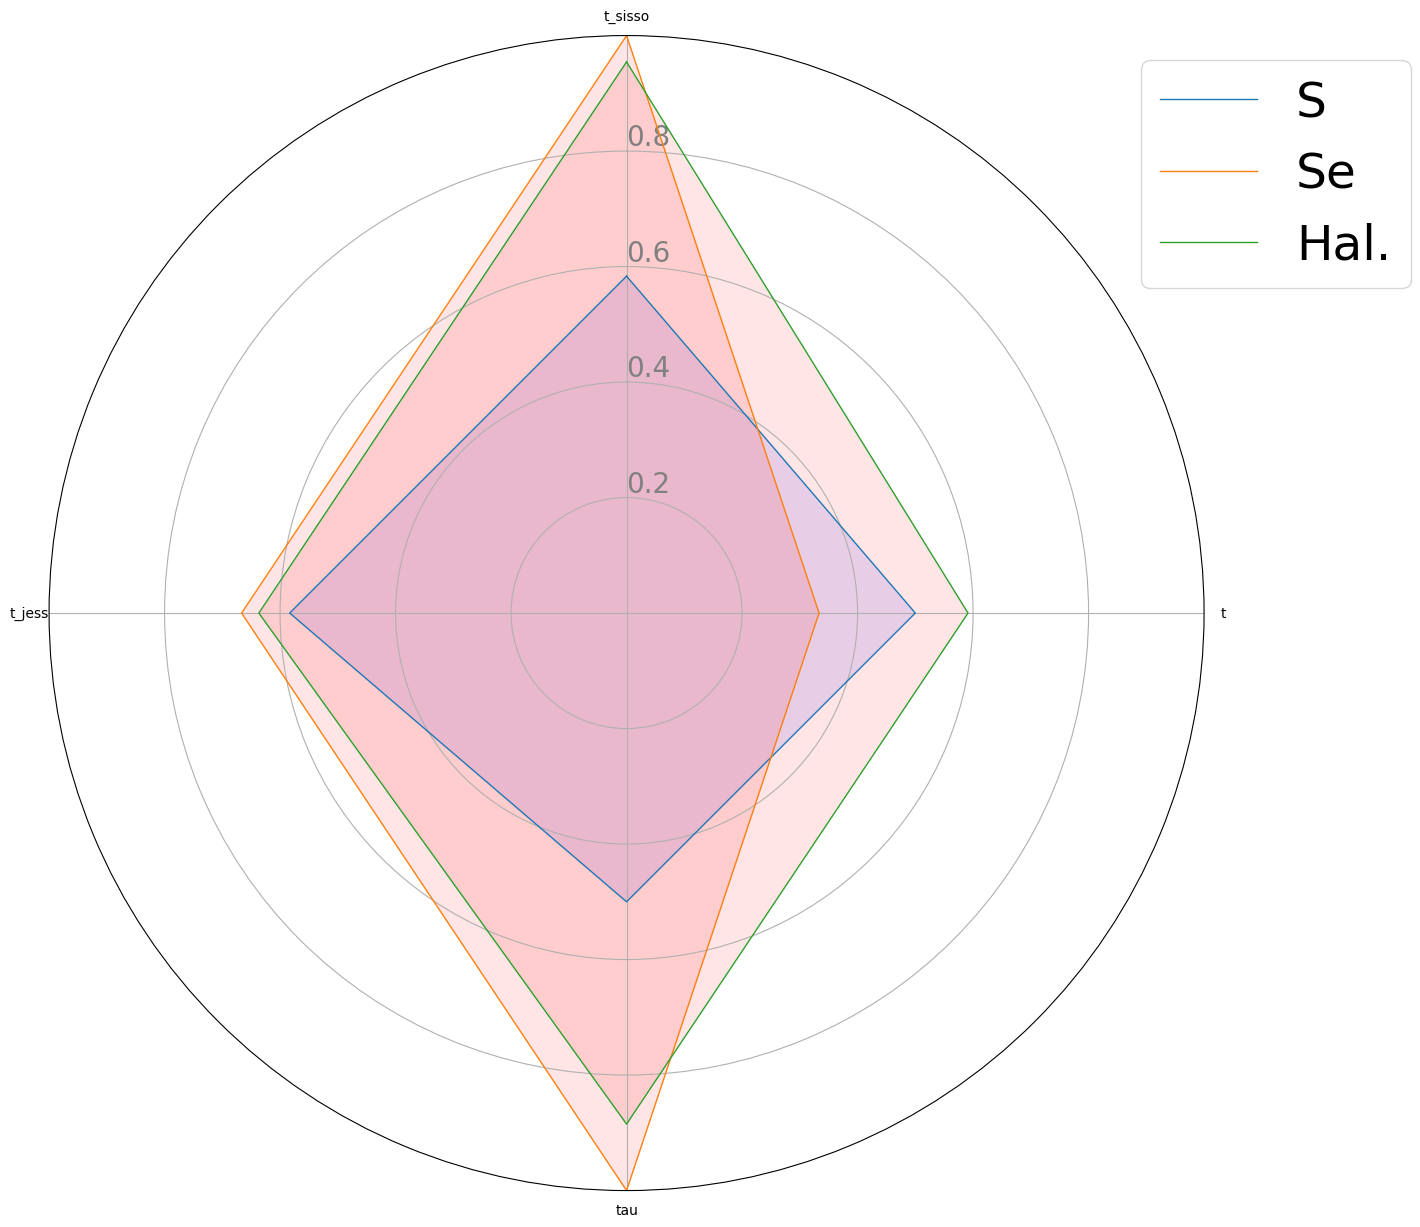

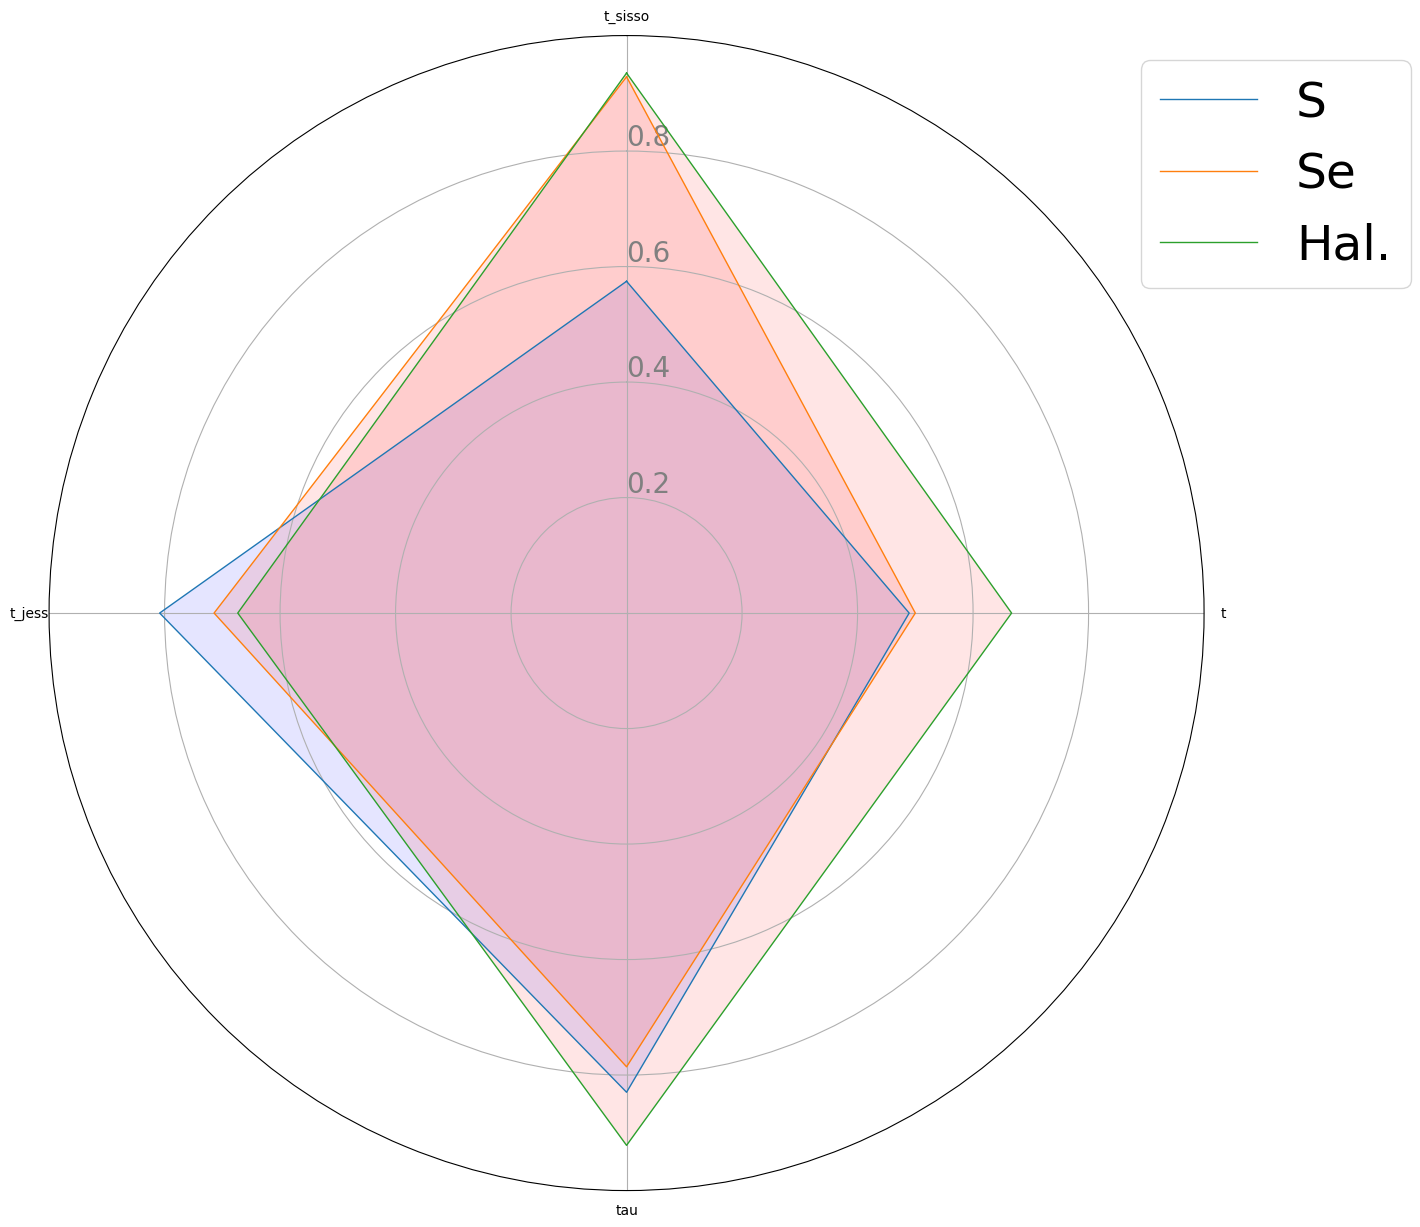

In [6]:
from tf_chpvk_pv.plots import spider_plot

test_idx = [x for x in df_acc.index if 'test' in x]
train_idx = [x for x in df_acc.index if 'train' in x]
test_acc = df_acc.loc[test_idx]
train_acc = df_acc.loc[train_idx]

test_acc.index = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']
train_acc.index = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']

#find mean for halides
test_hal = test_acc.loc[['I', 'Cl', 'Br', 'F']].mean(axis=0)
train_hal = train_acc.loc[['I', 'Cl', 'Br', 'F']].mean(axis=0)

test_acc['group'] = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']
train_acc['group'] = ['test_data', 'S', 'I', 'Cl','Br', 'F', 'Se']

test_acc.loc['hal'] = test_hal
test_acc.loc['hal', 'group'] = 'Hal.'

train_acc.loc['hal'] = train_hal
train_acc.loc['hal', 'group'] = 'Hal.'

spider_plot(test_acc, 'test data')
spider_plot(train_acc, 'train data')

In [7]:
train_df, test_df = train_platt_scaling(train_df, test_df, tolerance_factor_dict, clfs['t_sisso'])

2025-02-27 01:31:28.827 | INFO     | tf_chpvk_pv.modeling.train:train_platt_scaling:50 - Training Platt scaling model...
2025-02-27 01:31:28.903 | SUCCESS  | tf_chpvk_pv.modeling.train:train_platt_scaling:70 - Platt scaling model training complete.


Now let's create new possible compositions

In [8]:
from tf_chpvk_pv.dataset import generate_compositions
from tf_chpvk_pv.modeling.predict import check_stable_compositions

element_selection_A = ["Ba", "Eu", "Pb", "Sr", "Ca", "Sn", "Cd", "Cu", "Mg",
                      "Zn", "Ge", "La", "Pr", "Ce", "Nd", "Yb", "Gd", "Sm", "Y",
                      "Dy", "Ho", "Er", "Tm", "Lu", "Sc", "Tl", "Bi"]

elements_selection_B = ["Si", "Ge", "V", "Rh", "Ti", "Ru", "Mo", "Ta", "Nb", "Hf",
                        "Zr", "Tb", "Pt", "Ce", "U", "Pd", "Ni", "Co", "Ga", "Al",
                        "Fe", "Cr", "In", "Mn", "Sc", "Lu", "Tm", "Er", "Ho", "Y",
                        "Yb"]


elements_selection = element_selection_A + elements_selection_B

df_generated_comp = generate_compositions(elements_selection).dropna()

2025-02-27 01:31:28.917 | INFO     | tf_chpvk_pv.dataset:generate_compositions:245 - Generating valid compositions...
2025-02-27 01:31:36.354 | SUCCESS  | tf_chpvk_pv.dataset:generate_compositions:401 - 1192 valid compositions generated.


/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
from tf_chpvk_pv.plots import graph_periodic_table

stable_candidates_t_sisso, df_out = check_stable_compositions('t_sisso')

graph_periodic_table(stable_candidates_t_sisso)

NameError: name 'check_stable_compositions' is not defined

According to t_sisso, 385 (32.29865771812081%) compositions are predicted to be stable as perovskites:
['BaPbS3', 'BaPrS3', 'BaCeS3', 'BaHfS3', 'BaZrS3', 'BaTbS3', 'BaUS3', 'EuCuS3', 'EuCuSe3', 'EuScS3', 'EuScSe3', 'EuRhS3', 'EuRhSe3', 'EuMoS3', 'EuMoSe3', 'EuNiS3', 'EuNiSe3', 'EuCoS3', 'EuCoSe3', 'EuGaS3', 'EuGaSe3', 'EuAlS3', 'EuAlSe3', 'EuFeS3', 'EuFeSe3', 'EuCrS3', 'EuCrSe3', 'EuInS3', 'EuMnS3', 'EuMnSe3', 'CuLaS3', 'CuLaSe3', 'CuGaS3', 'CuAlS3', 'CuAlSe3', 'MgUS3', 'MgUSe3', 'LaYbS3', 'LaYbSe3', 'LaYS3', 'LaYSe3', 'LaHoS3', 'LaHoSe3', 'LaErS3', 'LaErSe3', 'LaTmS3', 'LaTmSe3', 'LaLuS3', 'LaLuSe3', 'LaScS3', 'LaScSe3', 'LaTlS3', 'LaTlSe3', 'LaVS3', 'LaVSe3', 'LaRhS3', 'LaRhSe3', 'LaTiS3', 'LaTiSe3', 'LaRuS3', 'LaRuSe3', 'LaMoS3', 'LaMoSe3', 'LaTaS3', 'LaTaSe3', 'LaNbS3', 'LaNbSe3', 'LaHfS3', 'LaNiS3', 'LaNiSe3', 'LaCoS3', 'LaCoSe3', 'LaGaS3', 'LaGaSe3', 'LaAlS3', 'LaAlSe3', 'LaFeS3', 'LaFeSe3', 'LaCrS3', 'LaCrSe3', 'LaInS3', 'LaInSe3', 'LaMnS3', 'LaMnSe3', 'PrLuS3', 'PrScS3', 'PrScS

/home/dagar/TF-ChPVK-PV/tf_chpvk_pv/plots.py:165: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements([x.replace('3', '') for x in stable_candidates_t_sisso])
/home/dagar/anaconda3/envs/tf_chpvk_pv/lib/python3.13/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


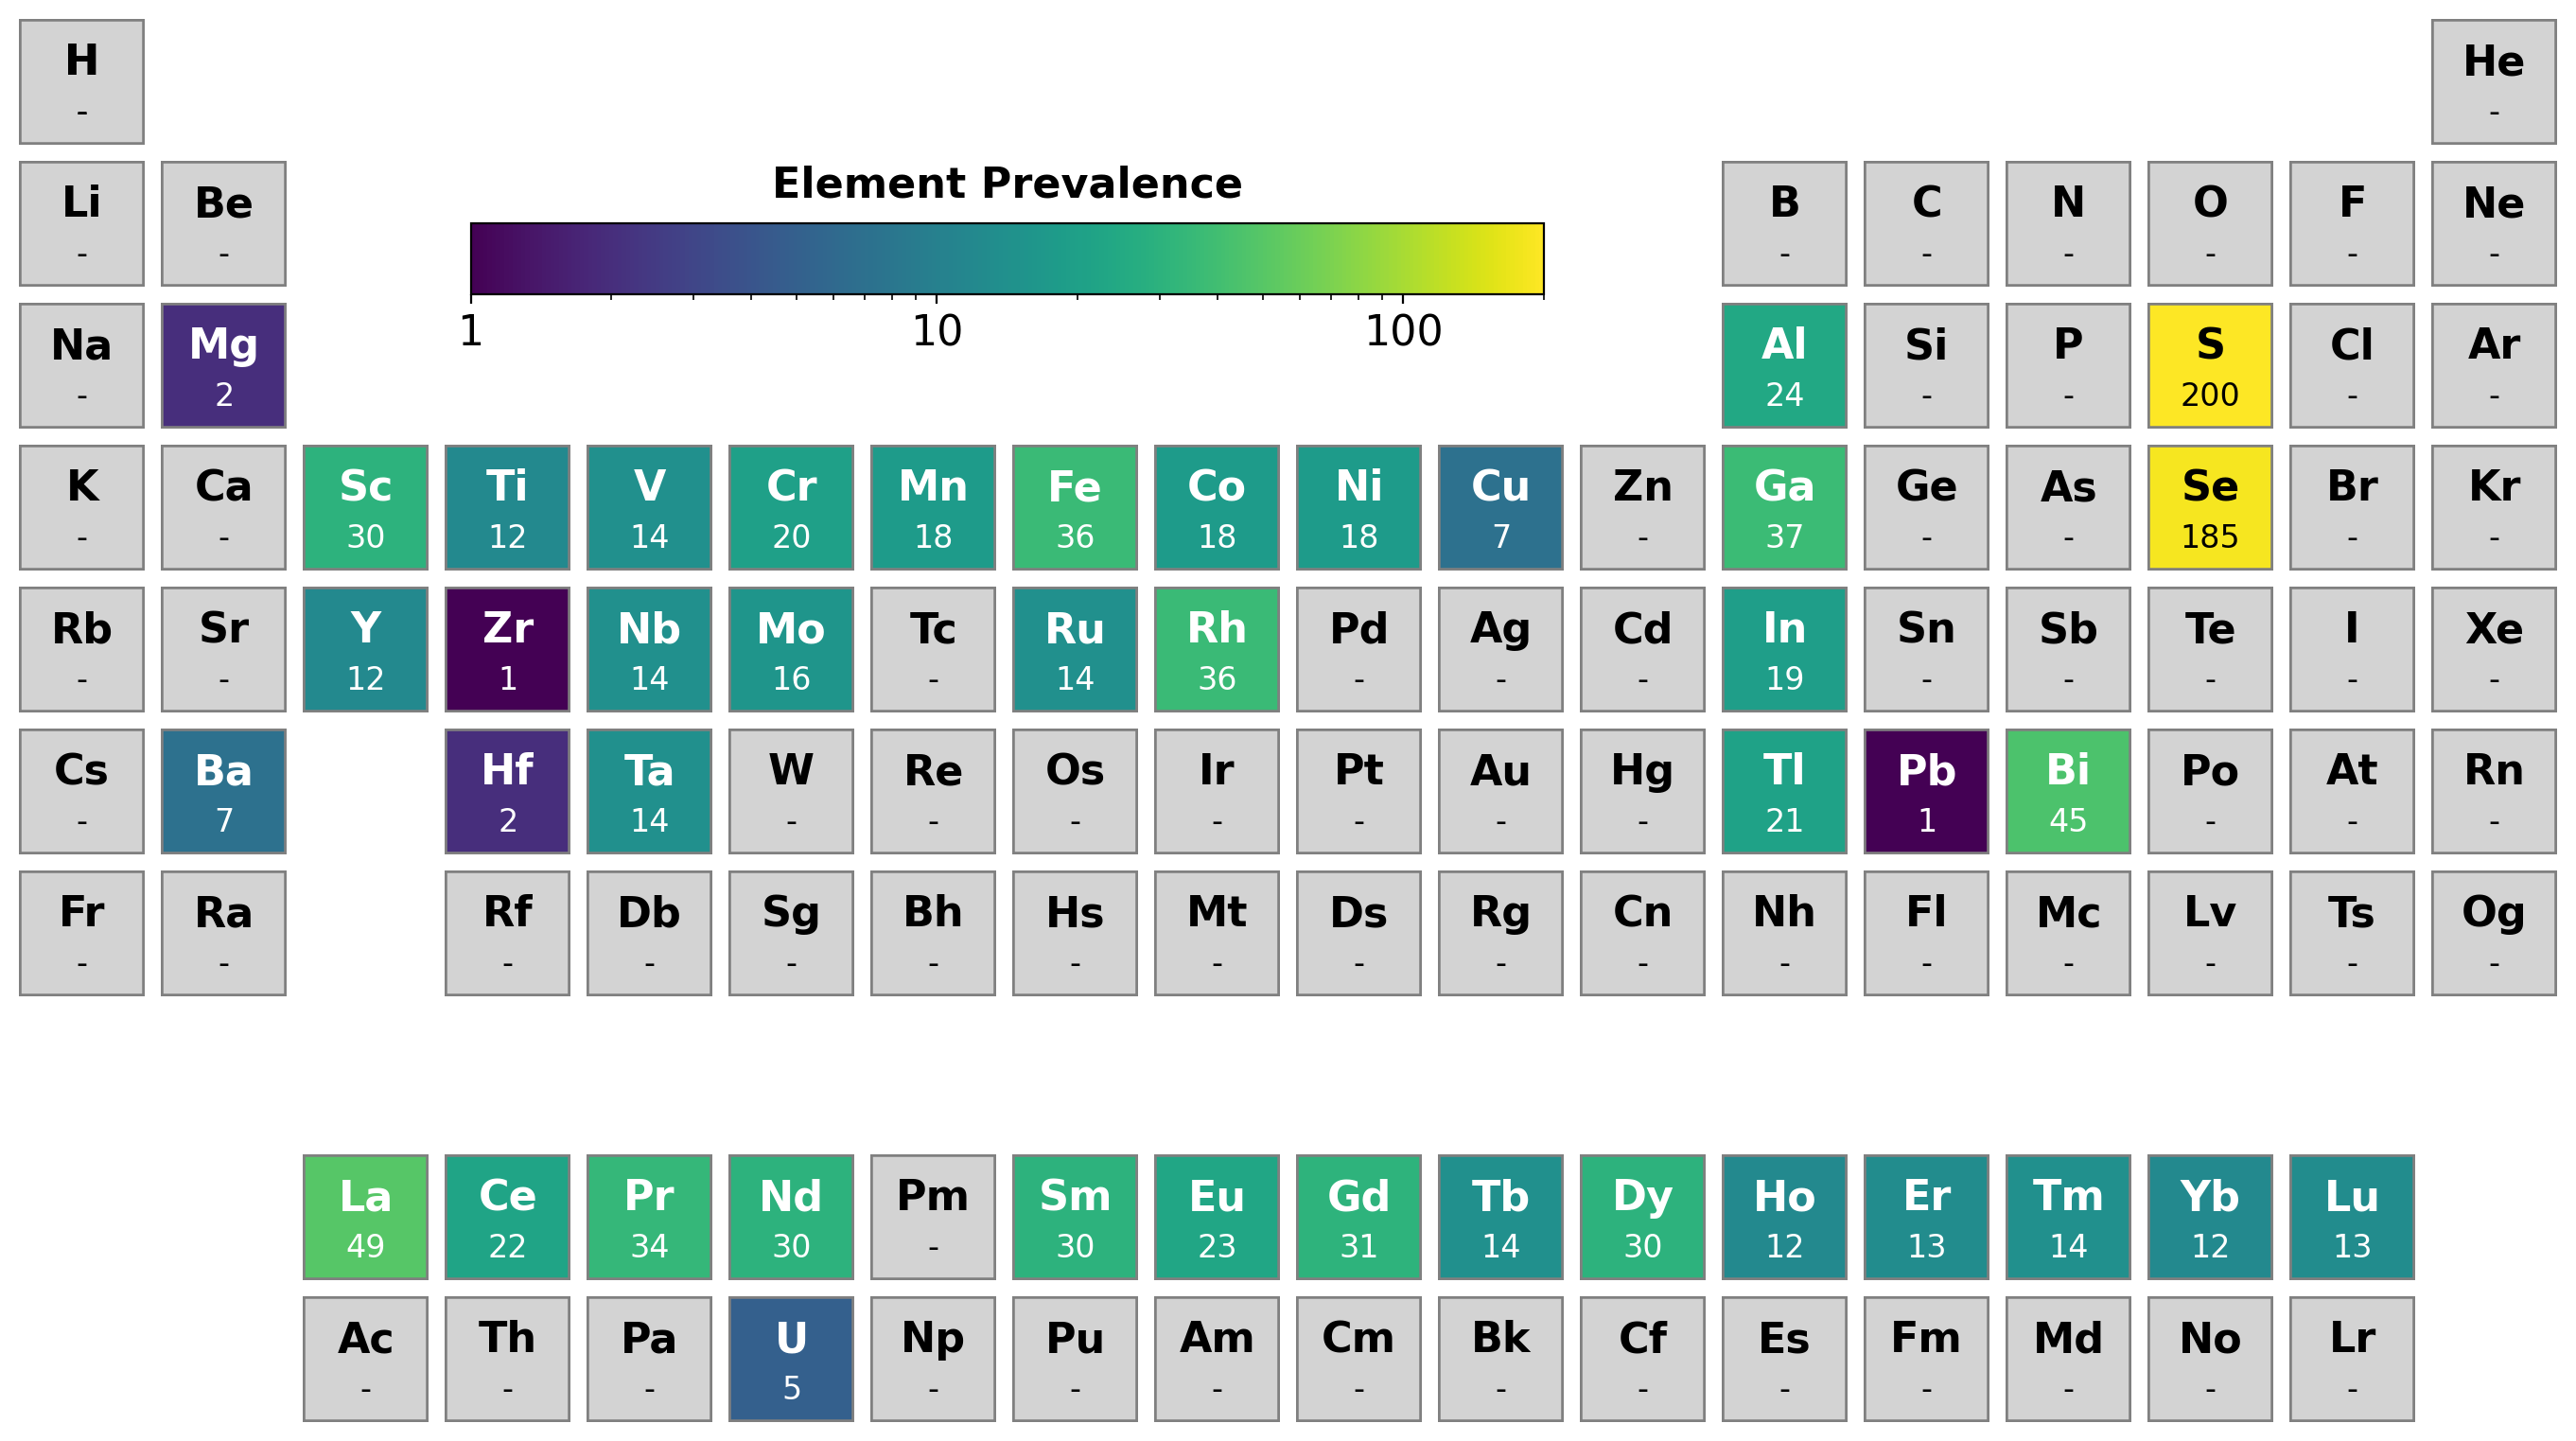

In [10]:
stable_candidates_tau, df_out = check_stable_compositions('tau')

graph_periodic_table(stable_candidates_tau, 'tau')